# 多个单词的词袋（n元分词）

使用词袋表示的主要缺点之一是完全舍弃了单词顺序。因此，"It's bad, not goodatall"(电影很差，一点也不好)和"it's good, not bad at all"(电影很好，还不错)这两个字符串的词袋表示完全相同，尽管它们的含义相反。将“not”(不) 放在单词前面，这只是上下文很重要的一个例子(可能是一个极端的例子)。幸运的是，使用词袋表示时有一种获取上下文的方法，就是不仅考虑单一词例的计数，而且还考虑相邻的两个或三个词例的计数。两个词例被称为**二元分词**(bigram)，三个词例被称为**三元分词** (trigram)，更一般的词例序列被称为**n元分词**(n-gram)。我们可以通过改变CountVectorizer 或TfidfVectorizer的ngram_range参数来改变作为特征的词例范围。ngram_range 参数是一个元组，包含要考虑的词例序列的最小长度和最大长度。下面是在之前用过的玩具数据上的一个示例:

In [1]:
bards_words = ["The fool doth think he is wise", "but the wise man knows himself to be a fool"]
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise', 'but the wise man knows himself to be a fool']


默认情况下，为每个长度最小为1且最大为1的词例序列 (或者换句话说，刚好1个词例)创建一个特征一单个词例也被称为一元分词 (unigram):

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_))) # vocabulary_ 访问词表
print("Vocabulary:\n{}".format(cv.get_feature_names_out())) # get_feature_names_out该方法用于获取变换后的特征名称

Vocabulary size: 13
Vocabulary:
['be' 'but' 'doth' 'fool' 'he' 'himself' 'is' 'knows' 'man' 'the' 'think'
 'to' 'wise']


要想仅查看二元分词(即仅查看由两个相邻词例组成的序列)，可以将ngram_range 设置为(2，2)

In [3]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_))) # vocabulary_ 访问词表
print("Vocabulary:\n{}".format(cv.get_feature_names_out())) # get_feature_names_out该方法用于获取变换后的特征名称

Vocabulary size: 14
Vocabulary:
['be fool' 'but the' 'doth think' 'fool doth' 'he is' 'himself to'
 'is wise' 'knows himself' 'man knows' 'the fool' 'the wise' 'think he'
 'to be' 'wise man']


使用更长的词例序列通常会得到更多的特征，也会得到更具体的特征。bard_words 的两个短语中没有相同的二元分词:

In [4]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


对于大多数应用而言，最小的词例数量应该是1，因为单个单词通常包含丰富的含义。在大多数情况下，添加二元分词会有所帮助。添加更长的序列(一直到五元分词) 也可能有所帮助，但这会导致特征数量的大大增加，也可能会导致过拟合，因为其中包含许多非常具体的特征。原则上来说，二元分词的数量是一元分词数量的平方，三元分词的数量是一元分词数量的三次方，从而导致非常大的特征空间。在实践中，更高的 n 元分词在数据中的出现次数实际上更少，原因在于(英语) 语言的结构，不过这个数字仍然很大。

下面是在 bards_words 上使用一元分词、二元分词和三元分词的结果:

In [5]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_))) 
print("Vocabulary:\n{}".format(cv.get_feature_names_out())) 

Vocabulary size: 39
Vocabulary:
['be' 'be fool' 'but' 'but the' 'but the wise' 'doth' 'doth think'
 'doth think he' 'fool' 'fool doth' 'fool doth think' 'he' 'he is'
 'he is wise' 'himself' 'himself to' 'himself to be' 'is' 'is wise'
 'knows' 'knows himself' 'knows himself to' 'man' 'man knows'
 'man knows himself' 'the' 'the fool' 'the fool doth' 'the wise'
 'the wise man' 'think' 'think he' 'think he is' 'to' 'to be' 'to be fool'
 'wise' 'wise man' 'wise man knows']


我们在IMDb电影评论数据上尝试使用 TfidfVectorizer，并利用网格搜索找出n元分词的最佳设置:

In [6]:
from sklearn.datasets import load_files
import numpy as np
reviews_train = load_files("E:/clone/machine-learning/data/aclImdb/train/")
# load_files返回一个Bunch对象，其中包含训练文本和训练标签

data_array = np.array(reviews_train.data)
target_array = np.array(reviews_train.target)

# Filter out documents where the target is not equal to 2
labeled_indices = np.where(target_array != 2)[0]
text_train, y_train = data_array[labeled_indices], target_array[labeled_indices]
text_train = [doc.replace(b'<br />',b' ') for doc in text_train]

reviews_test = load_files("E:/clone/machine-learning/data/aclImdb/test/")
data_array = np.array(reviews_test.data)
target_array = np.array(reviews_test.target)
text_test, y_test = data_array, target_array
text_test = [doc.replace(b'<br />',b' ') for doc in text_test]

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.3f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:

Best cross-validation score: 0.906
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


从结果中可以看出，我们添加了二元分词特征与三元分词特征之后，性能提高了一个百分点多一点。我们可以将交叉验证精度作为 ngram_range 和C参数的函数并用热图可视化

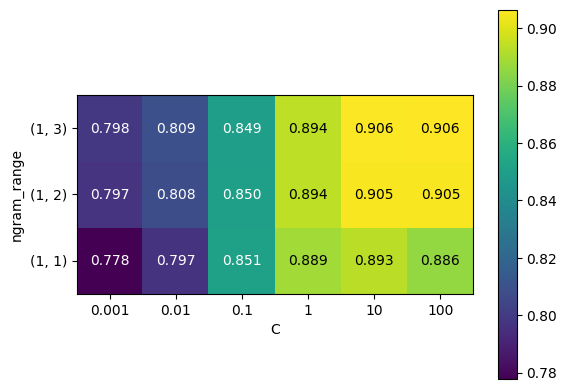

In [9]:
# 交叉验证平均精度作为参数ngram_range和c的函数的热图可视化

# 从网格搜索中提取分数
import mglearn
import matplotlib.pyplot as plt
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# 热图可视化
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'], 
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

从热图中可以看出，使用二元分词对性能有很大提高，而添加三元分词对精度只有很小贡献。为了更好地理解模型是如何改进的，我们可以将最佳模型的重要系数可视化，其中包含一元分词、二元分词和三元分词 

(-22.0, 22.0)

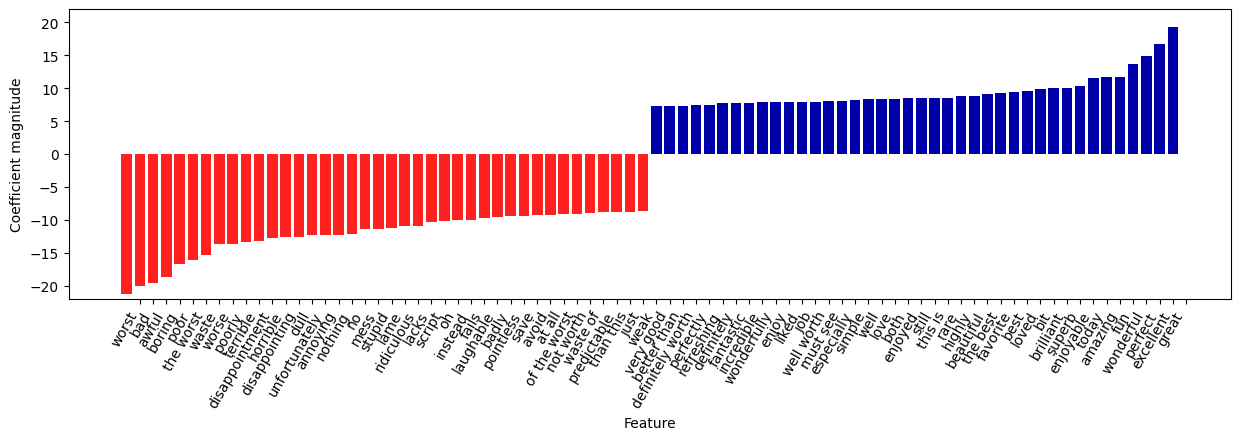

In [11]:
# 同时使用tf-idf缩放与一元分词、二元分词和三元分词时的最重要特征

# 提取特征名称与系数
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_  # 斜率”参数(w，也叫作权重或系数)被保存在coef_属性中
# 而偏移或截距 (b)被保存在intercept 属性中
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

有几个特别有趣的特征，它们包含单词“worth”(值得)，而这个词本身并没有出现在一元分词模型中:"not worth”(不值得)表示负面评论，而"definitely worth”(绝对值得)和“well worth”(很值得)表示正面评论。这是上下文影响“worth"一词含义的主要示例。

接下来，我们只将三元分词可视化，以进一步深人了解这些特征有用的原因。许多有用的二元分词和三元分词都由常见的单词组成，这些单词本身可能没有什么信息量，比如"none of the"(没有一个)、"the only good”(唯一好的)"on and on”(不停地)、"thisis one”(这是一部)"of the most”(最)等短语中的单词。但是，与一元分词特征的重要性相比，这些特征的影响非常有限。

(-22.0, 22.0)

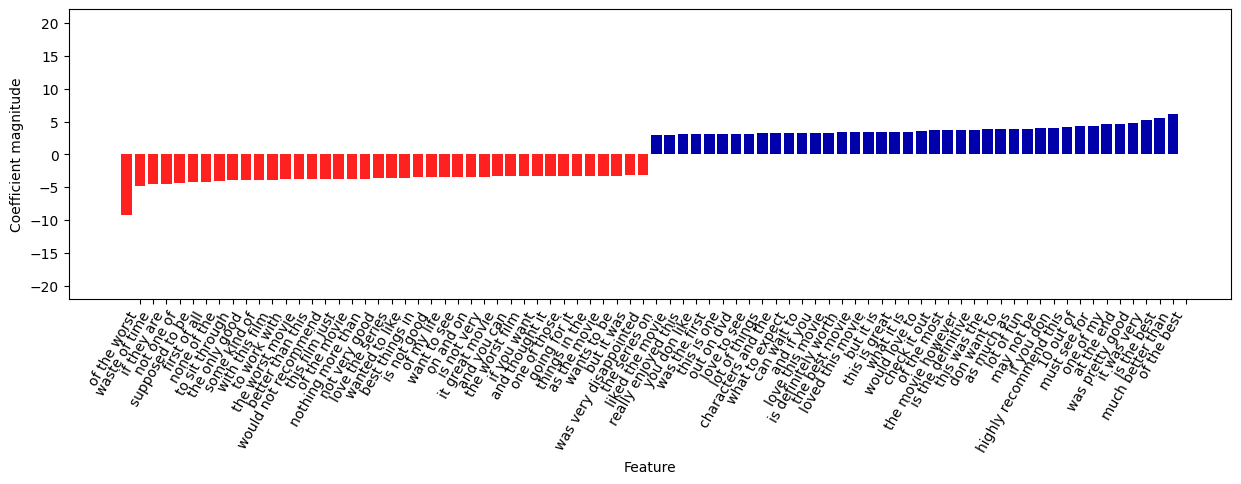

In [12]:
# 仅将对模型重要的三元分词特征可视化

# 找到三元分词特征
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# 仅将三元分词特征可视化
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)
plt.ylim(-22, 22)